In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion
from scipy.special import softmax

In [44]:
class Policy:
    def __init__(self, env: gym.Env, action_space: list[int], gamma_min: float = 0.05, gamma_max: float = 4.0, gamma_count: int = 10, components: int = 250):
        transformers = [RBFSampler(n_components=components, gamma=g) for g in np.linspace(gamma_min, gamma_max, gamma_count)]
        state = env.reset()[0]
        self.action_space: list = action_space
        self.transformers: FeatureUnion = FeatureUnion([(str(t), t) for t in transformers])
        self.transformers.fit(state.reshape(1, -1))
        self.weights: npt.NDArray = np.random.rand(len(action_space), gamma_count * components)

    def _transform(self, state: npt.NDArray) -> npt.NDArray:
        return np.ravel(self.transformers.transform(state.reshape(1, -1)))

    def _combinations(self, transformed: npt.NDArray) -> npt.NDArray:
        return [np.dot(transformed, self.weights[action]) for action in self.action_space]

    def _probabilities(self, combinations: npt.NDArray) -> npt.NDArray:
        return softmax(combinations)

    def policy(self, state: npt.NDArray) -> int:
        transformed = self._transform(state)
        combinations = self._combinations(transformed)
        probabilities = self._probabilities(combinations)

        idx = np.argmax(probabilities)
        return self.action_space[idx]

    def update(self, state: npt.NDArray, action: int, multiplier: float) -> None:
        transformed = self._transform(state)
        combinations = self._combinations(transformed)
        probabilities = self._probabilities(combinations)
        expected = np.average(combinations, weights=probabilities)

        idx = self.action_space.index(action)
        gradient = combinations[idx] - expected
        self.weights[idx] += multiplier * gradient

In [45]:
class Reinforce:
    def __init__(self, env: gym.Env, num_episodes: int = 1000, alpha: float = 0.001, gamma: float = 0.99, render: bool = False) -> None:
        self.env: gym.Env = env
        self.num_episodes: int = num_episodes
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.render: bool = render

        self.policy: Policy = Policy(env, [0, 1])

    def generate_episode(self) -> list[tuple]:
        transitions = []
        done = False
        state = self.env.reset()[0]
        while not done:
            action = self.policy.policy(state)
            _, reward, terminated, truncated, _ = self.env.step(action)
            transitions.append((state, action, reward))
            done = terminated or truncated
        return transitions

    def train(self) -> tuple[list[int]]:
        lives = []
        rewards = []
        for _ in range(self.num_episodes):
            transitions = self.generate_episode()

            # Get discounted total returns for each time step.
            returns = []
            current_return = 0
            total = 0
            for _, _, reward in reversed(transitions):
                current_return += reward
                returns.append(current_return)
                current_return *= self.gamma
                total += reward
            returns.reverse()

            # Save stats.
            lives.append(len(transitions))
            rewards.append(total)

            # Update weights.
            for t, (state, action, _) in enumerate(transitions):
                multiplier = self.alpha * (self.gamma ** t) * returns[t]
                self.policy.update(state, action, multiplier)

                if self.render:
                    self.env.render()

        return lives, rewards

In [46]:
# env = gym.make("MountainCar-v0")
env = gym.make("CartPole-v1")
agent = Reinforce(env)
info = agent.train()

10.0
[-0.0034698673360802667, 0.0017691323401854537]
[-0.0034698673360802667, 0.0017682533111615909]
[-0.0034698673360802667, 0.00176746634526017]
[-0.0034698673360802667, 0.0017667704805064172]
[-0.0034698673360802667, 0.0017661647694240633]
[-0.0034698673360802667, 0.0017656482787757896]
[-0.0034698673360802667, 0.0017652200893091825]
[-0.0034698673360802667, 0.001764879295507922]
[-0.0034698673360802667, 0.0017646250053482558]
[-0.0034698673360802667, 0.0017644563400604648]
10.0
[-0.016833165484124696, -0.014835195996787787]
[-0.016833165484124696, -0.014835172262519913]
[-0.016833165484124696, -0.014835151010198422]
[-0.016833165484124696, -0.014835132215083]
[-0.016833165484124696, -0.014835115852671355]
[-0.016833165484124696, -0.014835101898697179]
[-0.016833165484124696, -0.014835090329127896]
[-0.016833165484124696, -0.01483508112016257]
[-0.016833165484124696, -0.014835074248229779]
[-0.016833165484124696, -0.014835069689985506]
10.0
[0.0015358500174273981, -0.005127677265837

Text(0, 0.5, 'Lifespan (# steps)/Episode Reward')

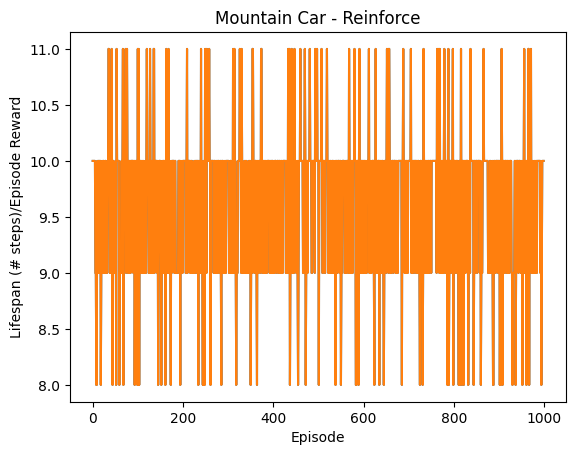

In [47]:
plt.plot(range(len(info[0])), info[0])
plt.plot(range(len(info[0])), info[1])
plt.title("Mountain Car - Reinforce")
plt.xlabel("Episode")
plt.ylabel("Lifespan (# steps)/Episode Reward")